In [1]:
#!mamba env create -f '../../environment.yml'
#!mamba env update -f '../../environment.yml' --prune

In [2]:
%load_ext autoreload
%autoreload 2

In [98]:
%aimport easysnowdata
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
import shapely
import dask
import pystac_client
import planetary_computer
import odc.stac
import matplotlib.pyplot as plt
import matplotlib.colors
import datetime

In [4]:
bbox_gdf = gpd.read_file('https://github.com/egagli/sar_snowmelt_timing/raw/main/input/shapefiles/mt_rainier.geojson')

In [5]:
%%time
forest_cover_fraction = easysnowdata.remote_sensing.get_forest_cover_fraction(bbox_gdf)
forest_cover_fraction

CPU times: user 24.7 ms, sys: 13.4 ms, total: 38.1 ms
Wall time: 5.11 s


<xarray.DataArray (y: 158, x: 232)> Size: 147kB
dask.array<getitem, shape=(158, 232), dtype=float32, chunksize=(158, 232), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 2kB -121.9 -121.9 -121.9 ... -121.6 -121.6 -121.6
  * y            (y) float64 1kB 46.95 46.95 46.95 46.95 ... 46.8 46.79 46.79
    spatial_ref  int64 8B 0
Attributes: (12/31)
    archive_facility:       VITO NV
    AREA_OR_POINT:          Area
    copyright:              Copernicus Service information 2020
    creator:                Dr. Marcel Buchhorn (VITO)
    delivered_product_crs:  WGS84 (EPSG:4326)
    doi:                    10.5281/zenodo.3939050
    ...                     ...
    time_reference_year:    2019
    title:                  Dynamic Land Cover Map 100m 2019-nrt
    band_crs:               WGS84 (EPSG:4326)
    short_name:             Tree-CoverFraction-layer
    unit:                   %
    valid_range:            0, 100

Text(0.5, 1.0, 'Copernicus Global Land Service Forest Cover Fraction\nLand Cover 100m: collection 3: epoch 2019')

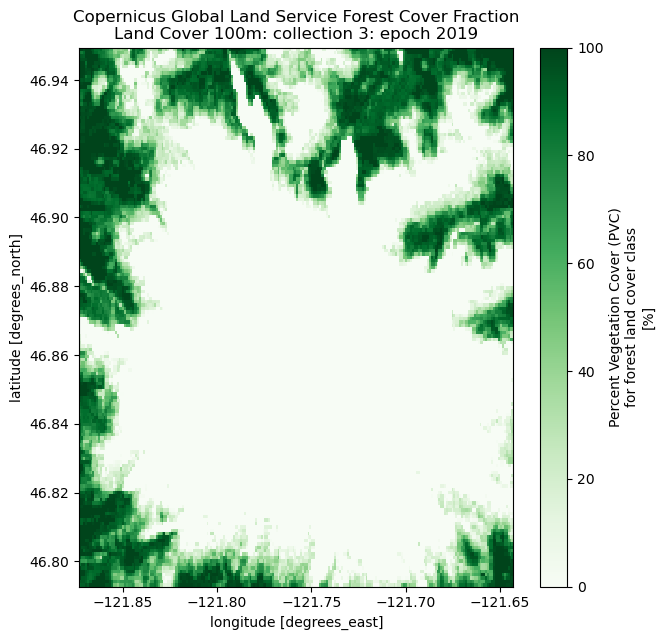

In [6]:
f,ax=plt.subplots(figsize=(7,7))

forest_cover_fraction.plot(ax=ax,cmap='Greens')

ax.set_title('Copernicus Global Land Service Forest Cover Fraction\nLand Cover 100m: collection 3: epoch 2019')

In [7]:
%%time
snow_classification = easysnowdata.remote_sensing.get_seasonal_snow_classification(bbox_gdf)
snow_classification

CPU times: user 19.4 ms, sys: 0 ns, total: 19.4 ms
Wall time: 2.19 s


<xarray.DataArray (y: 57, x: 84)> Size: 19kB
dask.array<getitem, shape=(57, 84), dtype=float32, chunksize=(30, 84), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 672B -121.9 -121.9 -121.9 ... -121.6 -121.6 -121.6
  * y            (y) float64 456B 46.95 46.95 46.94 46.94 ... 46.8 46.8 46.79
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    Band_1:         Band 1
    long_name:      Band 1
    class_info:     {1: {'name': 'Tundra', 'color': '#a100c8'}, 2: {'name': '...

Text(0.5, 1.0, 'Seasonal Snow Classification\nfrom Sturm & Liston 2021')

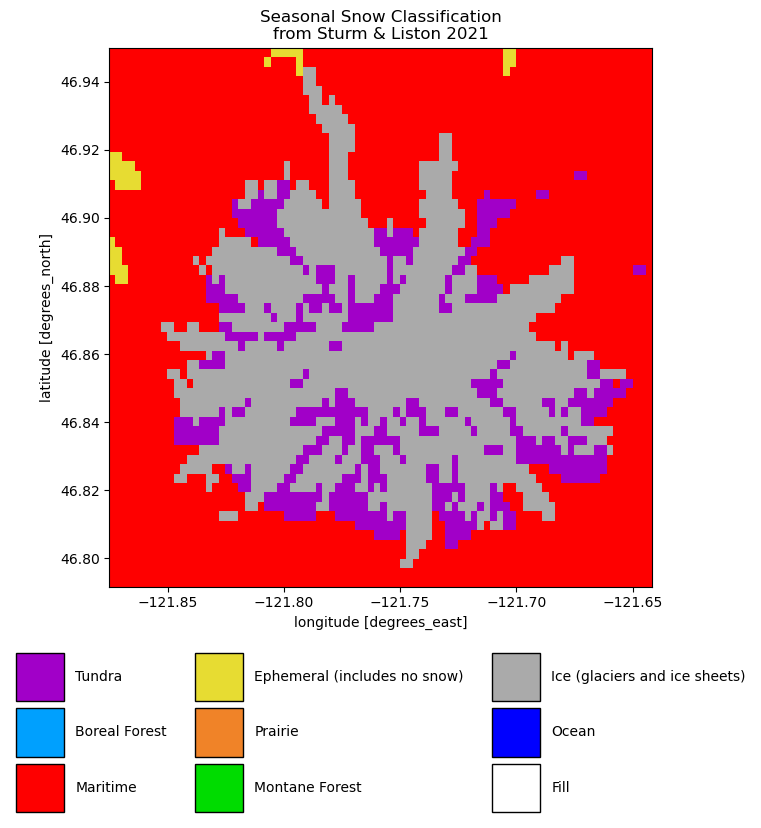

In [8]:
f,ax=plt.subplots(figsize=(7,7))

# Get the class names and class colors from the attributes
class_names = [class_info['name'] for class_info in snow_classification.attrs['class_info'].values()]
class_colors = [class_info['color'] for class_info in snow_classification.attrs['class_info'].values()]

# Create a colormap using the class colors
cmap = plt.cm.colors.ListedColormap(class_colors)
class_values = sorted(list(snow_classification.attrs['class_info'].keys()))
bounds = [(class_values[i] + class_values[i+1]) / 2 for i in range(len(class_values) - 1)]
bounds = [class_values[0] - 0.5] + bounds + [class_values[-1] + 0.5]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# Plot the snow_classification DataArray
snow_classification.plot.imshow(ax=ax,cmap=cmap, add_colorbar=False, norm=norm)

# Add a legend with the class names outside of the plot
legend_handles = []
for i, class_name in enumerate(class_names):
    legend_handles.append(plt.Rectangle((0, 0), 1, 1, facecolor=class_colors[i], edgecolor='black'))
ax.legend(legend_handles, class_names, bbox_to_anchor=(0.5, -0.1), loc='upper center',ncol=len(class_names)/3,frameon=False,handlelength=3.5, handleheight=5)

ax.set_title('Seasonal Snow Classification\nfrom Sturm & Liston 2021')

In [9]:
%%time
esa_worldcover = easysnowdata.remote_sensing.get_esa_worldcover(bbox_gdf)
esa_worldcover

CPU times: user 41.5 ms, sys: 0 ns, total: 41.5 ms
Wall time: 1.81 s


<xarray.DataArray 'map' (latitude: 1874, longitude: 2757)> Size: 5MB
dask.array<getitem, shape=(1874, 2757), dtype=uint8, chunksize=(1874, 2757), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 15kB 46.95 46.95 46.95 ... 46.79 46.79 46.79
  * longitude    (longitude) float64 22kB -121.9 -121.9 -121.9 ... -121.6 -121.6
    spatial_ref  int32 4B 4326
    time         datetime64[ns] 8B 2021-01-01
Attributes:
    nodata:      0
    class_info:  {10: {'name': 'Tree cover', 'color': '#006400'}, 20: {'name'...

Text(0.5, 1.0, 'ESA WorldCover\n2021 v200')

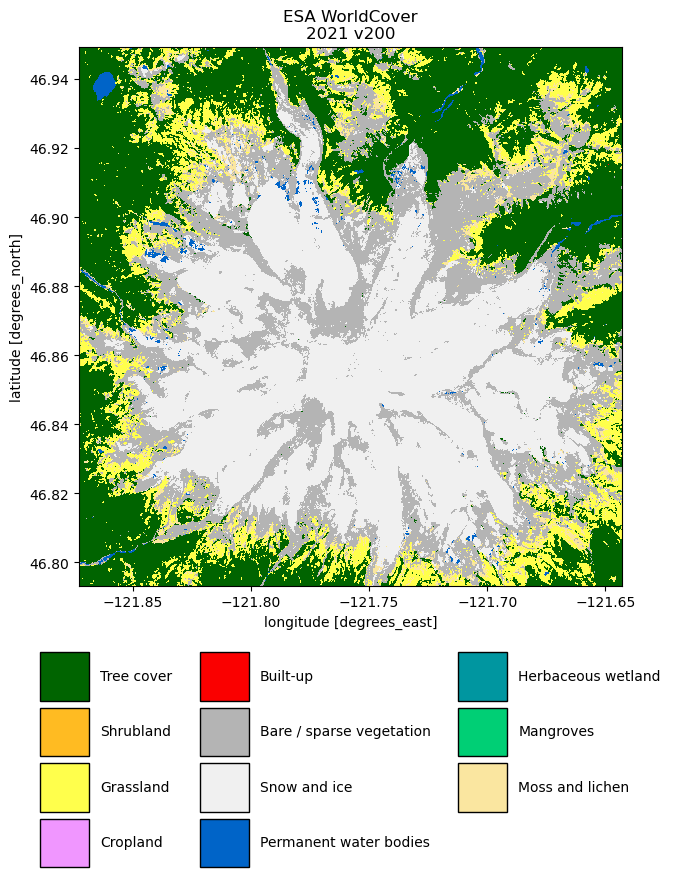

In [10]:
f,ax=plt.subplots(figsize=(7,7))

# Get the class names and class colors from the attributes
class_names = [class_info['name'] for class_info in esa_worldcover.attrs['class_info'].values()]
class_colors = [class_info['color'] for class_info in esa_worldcover.attrs['class_info'].values()]

# Create a colormap using the class colors
cmap = plt.cm.colors.ListedColormap(class_colors)
class_values = sorted(list(esa_worldcover.attrs['class_info'].keys()))
bounds = [(class_values[i] + class_values[i+1]) / 2 for i in range(len(class_values) - 1)]
bounds = [class_values[0] - 0.5] + bounds + [class_values[-1] + 0.5]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# Plot the snow_classification DataArray
esa_worldcover.plot.imshow(ax=ax,cmap=cmap, add_colorbar=False, norm=norm)

# Add a legend with the class names outside of the plot
legend_handles = []
for i, class_name in enumerate(class_names):
    legend_handles.append(plt.Rectangle((0, 0), 1, 1, facecolor=class_colors[i], edgecolor='black'))
ax.legend(legend_handles, class_names, bbox_to_anchor=(0.5, -0.1), loc='upper center',ncol=len(class_names)/3,frameon=False,handlelength=3.5, handleheight=5)

ax.set_title('ESA WorldCover\n2021 v200')

In [146]:
s2 = easysnowdata.remote_sensing.Sentinel2(bbox_input=bbox_gdf, start_date='2022-01-01', end_date='2022-12-31', catalog_choice='planetarycomputer')

In [147]:
s2.get_rgb()

<xarray.DataArray (band: 3, time: 145, y: 1763, x: 1779)> Size: 3GB
dask.array<stack, shape=(3, 145, 1763, 1779), dtype=uint16, chunksize=(1, 1, 1763, 1779), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 14kB 5.2e+06 5.2e+06 ... 5.183e+06 5.183e+06
  * x            (x) float64 14kB 5.858e+05 5.858e+05 ... 6.036e+05 6.036e+05
    spatial_ref  int32 4B 32610
  * time         (time) datetime64[ns] 1kB 2022-01-02T19:07:59.024000 ... 202...
  * band         (band) object 24B 'red' 'green' 'blue'
Attributes:
    band_info:  {'B01': {'name': 'coastal', 'description': 'Coastal aerosol, ...

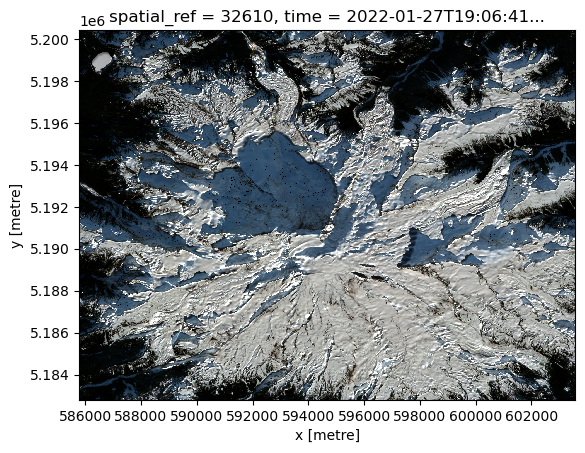

In [148]:
s2.rgb.isel(time=10).plot.imshow(robust=True)

In [149]:
scl_da = s2.data.scl.isel(time=10)

Text(0.5, 1.0, 'Sentinel-2 SCL')

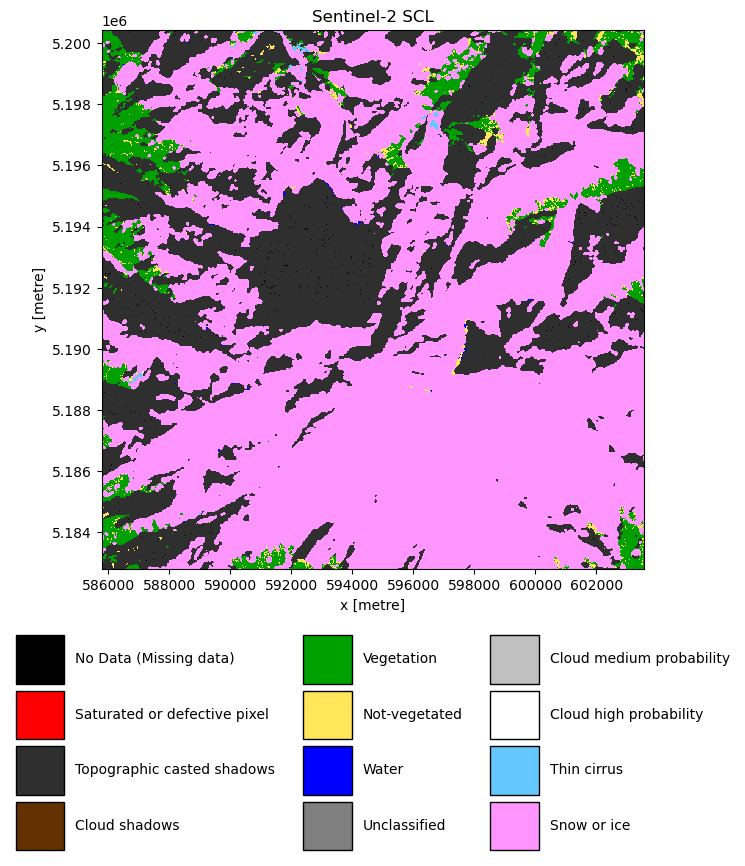

In [150]:
f,ax=plt.subplots(figsize=(7,7))

# Get the class names and class colors from the attributes
class_names = [class_info['name'] for class_info in scl_da.attrs['scl_class_info'].values()]
class_colors = [class_info['color'] for class_info in scl_da.attrs['scl_class_info'].values()]

# Create a colormap using the class colors
cmap = plt.cm.colors.ListedColormap(class_colors)
class_values = sorted(list(scl_da.attrs['scl_class_info'].keys()))
bounds = [(class_values[i] + class_values[i+1]) / 2 for i in range(len(class_values) - 1)]
bounds = [class_values[0] - 0.5] + bounds + [class_values[-1] + 0.5]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# Plot the snow_classification DataArray
scl_da.plot.imshow(ax=ax,cmap=cmap, add_colorbar=False, norm=norm)

# Add a legend with the class names outside of the plot
legend_handles = []
for i, class_name in enumerate(class_names):
    legend_handles.append(plt.Rectangle((0, 0), 1, 1, facecolor=class_colors[i], edgecolor='black'))
ax.legend(legend_handles, class_names, bbox_to_anchor=(0.5, -0.1), loc='upper center',ncol=len(class_names)/4,frameon=False,handlelength=3.5, handleheight=5)

ax.set_title('Sentinel-2 SCL')

In [151]:
s2.mask_data()

In [152]:
s2.get_ndsi()

<xarray.DataArray (time: 145, y: 1763, x: 1779)> Size: 2GB
dask.array<truediv, shape=(145, 1763, 1779), dtype=float32, chunksize=(1, 1763, 1779), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 14kB 5.2e+06 5.2e+06 ... 5.183e+06 5.183e+06
  * x            (x) float64 14kB 5.858e+05 5.858e+05 ... 6.036e+05 6.036e+05
    spatial_ref  int32 4B 32610
  * time         (time) datetime64[ns] 1kB 2022-01-02T19:07:59.024000 ... 202...

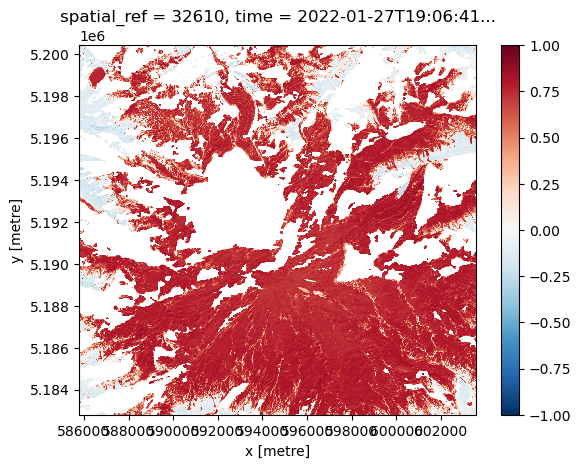

In [153]:
s2.ndsi.isel(time=10).plot.imshow()

In [154]:
s2.get_ndvi()

<xarray.DataArray (time: 145, y: 1763, x: 1779)> Size: 2GB
dask.array<truediv, shape=(145, 1763, 1779), dtype=float32, chunksize=(1, 1763, 1779), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 14kB 5.2e+06 5.2e+06 ... 5.183e+06 5.183e+06
  * x            (x) float64 14kB 5.858e+05 5.858e+05 ... 6.036e+05 6.036e+05
    spatial_ref  int32 4B 32610
  * time         (time) datetime64[ns] 1kB 2022-01-02T19:07:59.024000 ... 202...

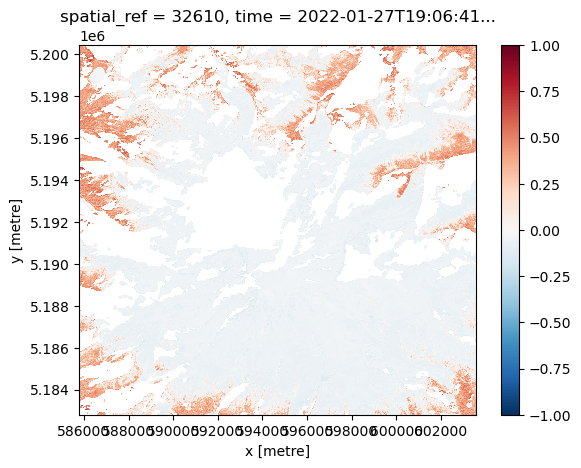

In [155]:
s2.ndvi.isel(time=10).plot.imshow()

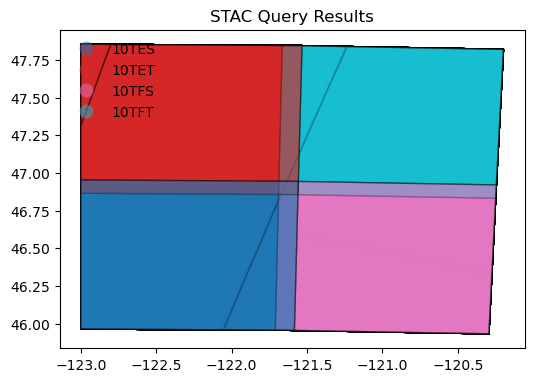

In [143]:
fig = s2.metadata.plot(
    "s2:mgrs_tile",
    edgecolor="black",
    categorical=True,
    aspect="equal",
    alpha=0.5,
    figsize=(6, 12),
    legend=True,
    legend_kwds={"loc": "upper left", "frameon": False, "ncol": 1},
)
_ = fig.set_title("STAC Query Results")

In [144]:
s2.metadata.explore(fill=False)

In [ ]:
#HLS https://lpdaac.usgs.gov/documents/842/HLS_Tutorial.html